In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

def generate_temperature_colormap(temperatures, cmap_name='coolwarm'):
    """
    Generate a colormap based on a list of temperature values.

    Parameters:
    temperatures (list or array): List of temperature values
    cmap_name (str): Name of the colormap to use (default is 'coolwarm')

    Returns:
    tuple: (colormap, norm) where colormap is a LinearSegmentedColormap and 
           norm is a Normalize object for mapping temperatures to colors
    """
    # Create a normalize object based on min and max temperatures
    norm = Normalize(vmin=min(temperatures), vmax=max(temperatures))
    
    # Create the colormap
    cmap = plt.get_cmap(cmap_name)
    
    # Create a LinearSegmentedColormap that's specific to our temperature range
    colors = cmap(norm(temperatures))
    custom_cmap = LinearSegmentedColormap.from_list("custom", colors)
    
    return custom_cmap, norm
    
def plot_data(
    df,
    x_name = 'h2so4',
    y_name = 'na2so4',
    series_name= 'temp',
    exclude_solids = None,
    title='',
    color_map = None,
    **style_kwargs,
):
    if exclude_solids is None:
        exclude_solids = []
    #prefilter
    _df = df.copy()
    _df = _df[~_df['solid'].isin(exclude_solids)]
    #plot bounds
    xmin = _df[x_name].min()
    xmax = _df[x_name].max()
    ymin = _df[y_name].min()
    ymax = _df[y_name].max()

    #build color map
    if color_map is None:
        temperatures = _df[series_name].unique().tolist()
        custom_cmap, norm = generate_temperature_colormap(temperatures, cmap_name='Blues')
    else:
        custom_cmap, norm = color_map
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    plt.close()
    
    temps = _df[series_name].unique().tolist()
    for temp in temps:
        color = custom_cmap(norm(temp))
        plot_df = _df[_df[series_name]==temp].copy()
        
        plot_df = plot_df.sort_values(by=[x_name])
        ax.plot(
            plot_df[x_name], plot_df[y_name], 
            label=temp,
            color=color,
            **style_kwargs,
        )
    ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    ax.set(
        title=title,
        xlabel=x_name, ylabel=y_name,
        xlim=(xmin, xmax), ylim=(ymin, ymax))
    return fig

def plot_data_test(
    df,
    x_name = 'h2so4',
    y_name = 'na2so4',
    series_name= 'temp',
    exclude_solids = None,
    title='',
    color_map = None,
    **style_kwargs,
):
    if exclude_solids is None:
        exclude_solids = []
    #prefilter
    _df = df.copy()
    _df = _df[~_df['solid'].isin(exclude_solids)]
    #plot bounds
    xmin = _df[x_name].min()
    xmax = _df[x_name].max()
    ymin = _df[y_name].min()
    ymax = _df[y_name].max()

    #build color map
    if color_map is None:
        temperatures = _df[series_name].unique().tolist()
        custom_cmap, norm = generate_temperature_colormap(temperatures, cmap_name='Blues')
    else:
        custom_cmap, norm = color_map
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    plt.close()
    
    temps = _df[series_name].unique().tolist()
    for temp in temps:
        color = custom_cmap(norm(temp))
        
        temp_df = _df[_df[series_name]==temp].copy()
        label_i = 0
        for (solid), plot_df in temp_df.groupby(by=[series_name]):
            plot_df = plot_df.sort_values(by=[x_name])
            if label_i==0:
                label = temp
                label_i+=1
            else:
                label = '__no_legend__'
            ax.plot(
                plot_df[x_name], plot_df[y_name], 
                label=label,
                color=color,
                **style_kwargs,
            )
    ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    ax.set(
        title=title,
        xlabel=x_name, ylabel=y_name,
        xlim=(xmin, xmax), ylim=(ymin, ymax))
    return fig

In [2]:
def get_moles(mass : dict[str,float], mw: dict[str,float]):
    """mass is a dict of chemical : mass"""
    m_total = sum(mass.values())
    moles = {
        chemical : m/mw[chemical]
        for chemical, m in mass.items()
    }
    return moles

def get_molefracs(mass : dict[str,float], mw: dict[str,float]):
    """mass is a dict of chemical : mass"""
    m_total = sum(mass.values())
    moles = get_moles(mass, mw)
    n_total = sum(moles.values())
    molfracs = {
        chemical : n/n_total 
        for chemical, n in moles.items()
    }
    return molfracs
    
def get_mass_from_row(row):
    chemicals = ['h2o','h2so4','na2so4']
    mass = {
        chemical : row.get(chemical,0.0)
        for chemical in chemicals
    }
    return mass

def get_moles_from_row(row, chemical):
    mass = get_mass_from_row(row)
    moles = get_moles(mass, mw)
    return moles.get(chemical,0.0)
    
def get_molefrac_from_row(row, chemical):
    mass = get_mass_from_row(row)
    molfracs = get_molefracs(mass, mw)
    return molfracs.get(chemical,0.0)

#internal metrics
def get_mol_per_kg_h2o(row, chemical):
    kg_h2o = row['h2o']/1000.0
    n_chemical = row[f'n_{chemical}']
    return n_chemical/kg_h2o

In [3]:
from sklearn.base import BaseEstimator, RegressorMixin
class PowerRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.linear_regressor = LinearRegression()
    
    def fit(self, X, y):
        self.linear_regressor.fit(np.log(X), np.log(y))
        return self
    
    def predict(self, X):
        return np.exp(self.linear_regressor.predict(np.log(X)))

class ExponentialRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.linear_regressor = LinearRegression()
    
    def fit(self, X, y):
        self.linear_regressor.fit(X, np.log(y))
        return self
    
    def predict(self, X):
        return np.exp(self.linear_regressor.predict(X))

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

def get_fit_info(x,y, pipelines = None):
    if pipelines is None:
        pipelines = {
            "linear": make_pipeline(LinearRegression()),
            "poly_2": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
            "poly_3": make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
            "power": make_pipeline(PowerRegressor()),
            "exponential": make_pipeline(ExponentialRegressor())
        }
    
    results = {}
    X = x.reshape(-1, 1)

    for name, pipeline in pipelines.items():
        pipeline.fit(X, y)
        y_pred = pipeline.predict(X)
        
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        results[name] = {"pipeline": pipeline, "y_pred": y_pred, "mse": mse, "r2": r2}

    return results

def get_fit_df(fit_info):
    summary_data = []
    for name, metrics in fit_info.items():
        row = {"Model": name, "MSE": metrics["mse"], "R^2": metrics["r2"]}
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df


# Build a lookup table by molecule

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

import bizwiz
path_manager = bizwiz.PathManager(
    data_dir = "../data/"
)

csv_files = path_manager.find_data_files(suffix='.csv')
display(csv_files)
csv_file = csv_files[0]
print(f"csf_file: '{csv_file}'")

['../data/combined_data_cleaned.csv']

csf_file: '../data/combined_data_cleaned.csv'


## Raw Dataset

['-',
 'nahso4',
 'nahso4-h2o',
 'na3h(so4)2',
 'na2so4-10h2o',
 'nahso4 + na3h(so4)2 + nahso4-h2o',
 'na2so4']

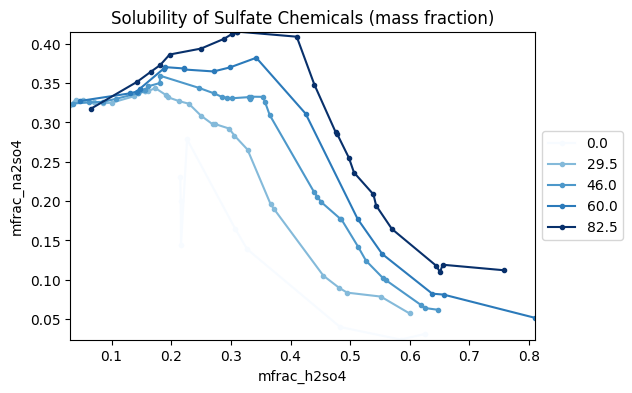

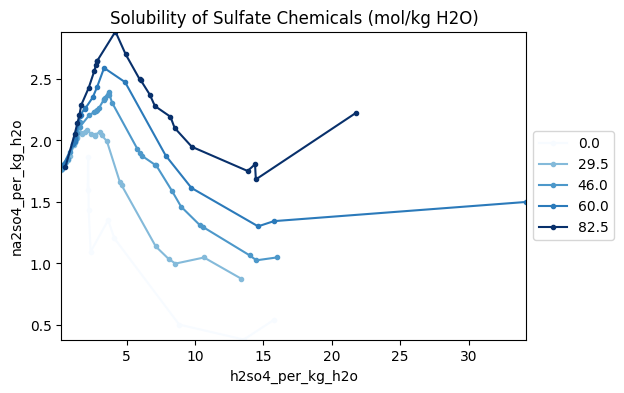

In [27]:
# 1. Load Raw Data
raw_df = pd.read_csv(csv_file)
raw_df = raw_df[['solid','temp','h2so4','na2so4']].copy()
raw_df['solid'] = raw_df['solid'].fillna(value='-') #blanks and nan become consistent character

# 2. process data for additional units
mw = {
    'h2o' : 18.01528,
    'h2so4' : 98.0720,
    'na2so4' : 142.0355,
}

# Close mass balance
#assume basis = 100.0 if percent
m_total = 100.0 #g
raw_df['h2o'] = raw_df.apply(lambda row: m_total - row['h2so4'] + row['na2so4'], axis=1)
#derived from main names
for chemical in ['h2o','h2so4','na2so4']:
    raw_df[f'm_{chemical}'] = raw_df[chemical] #assume basis is same
for chemical in ['h2o','h2so4','na2so4']:
    raw_df[f'mfrac_{chemical}'] = raw_df.apply(lambda row: row[chemical]/m_total, axis=1)
for chemical in ['h2o','h2so4','na2so4']:
    raw_df[f'n_{chemical}'] = raw_df.apply(lambda row: get_moles_from_row(row=row, chemical=chemical), axis=1)
for chemical in ['h2o','h2so4','na2so4']:
    raw_df[f'nfrac_{chemical}'] = raw_df.apply(lambda row: get_molefrac_from_row(row=row, chemical=chemical), axis=1)


raw_df['h2so4_per_kg_h2o'] = raw_df.apply(lambda row: get_mol_per_kg_h2o(row=row, chemical='h2so4'), axis=1)
raw_df['na2so4_per_kg_h2o'] = raw_df.apply(lambda row: get_mol_per_kg_h2o(row=row, chemical='na2so4'), axis=1)

# 3. Plot data
solids = raw_df['solid'].unique().tolist()
display(solids)
fig = plot_data(
    raw_df,
    x_name = 'mfrac_h2so4',
    y_name = 'mfrac_na2so4',
    series_name= 'temp',
    title='Solubility of Sulfate Chemicals (mass fraction)',
    exclude_solids=['-'],
    marker='.',
)
display(fig)
fig = plot_data(
    raw_df,
    x_name = 'h2so4_per_kg_h2o',
    y_name = 'na2so4_per_kg_h2o',
    series_name= 'temp',
    title='Solubility of Sulfate Chemicals (mol/kg H2O)',
    exclude_solids=['-'],
    marker='.',
)
display(fig)
ax = fig.axes[0]
ax.set_xlim(0,20)
ax.set_ylim(0,12)
fig.savefig('russian_mol_per_kg_h2O.png', dpi=330, transparent=True, bbox_inches='tight')

## Interpolated dataset

Skipping solid='-', temp=0.0
-- Bad MSE [55.67235777763568]. Skipping fit for now
Skipping solid='-', temp=29.5
-- Bad MSE [23.715191204510774]. Skipping fit for now
Skipping solid='-', temp=46.0
-- Bad MSE [10.82865831890644]. Skipping fit for now
Skipping solid='-', temp=60.0
-- Bad MSE [27.246000636035024]. Skipping fit for now
Skipping solid='-', temp=82.5
-- Bad MSE [37.038967364675536]. Skipping fit for now
Skipping solid='na2so4-10h2o', temp=29.5
-- Not enough data to fit Skipping fit for now
Skipping solid='na3h(so4)2', temp=0.0
-- Not enough data to fit Skipping fit for now
Skipping solid='nahso4', temp=0.0
-- Not enough data to fit Skipping fit for now
Skipping solid='nahso4', temp=29.5
-- Not enough data to fit Skipping fit for now
Skipping solid='nahso4', temp=82.5
-- Bad MSE [1.3688867130907427]. Skipping fit for now
Skipping solid='nahso4 + na3h(so4)2 + nahso4-h2o', temp=29.5
-- Not enough data to fit Skipping fit for now


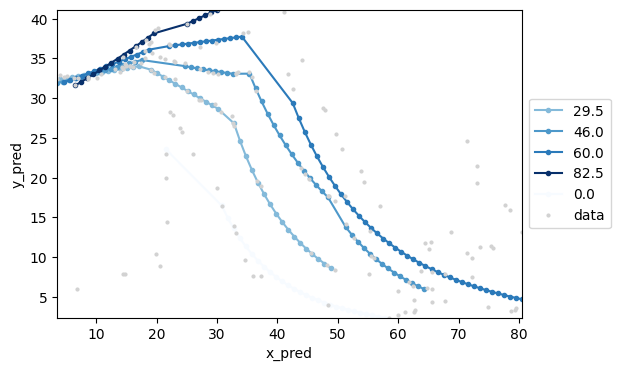

In [49]:
# Compute Smoothed Dataset for lookup
x_name = 'h2so4'
y_name = 'na2so4'

# x_name = 'h2so4_per_kg_h2o'
# y_name = 'na2so4_per_kg_h2o'
# 1. Determine best interpolation model to available data
# - choose possible fitting models
pipelines = {
    "linear": make_pipeline(LinearRegression()),
    # "poly_2": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    # "poly_3": make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
    "power": make_pipeline(PowerRegressor()),
    "exponential": make_pipeline(ExponentialRegressor())
}

# - process data by chemical solid and temp (curve shapes)
stats_df = pd.DataFrame()
for (solid, temp), df in raw_df.groupby(by=['solid', 'temp']):
    stats = {
        "solid" : solid,
        "temp" : temp,
    }
    #fitting flags
    stats.update({
        "count" : df.shape[0],
    })

    if df.shape[0]>=2:
        #test possible fits on segment
        x = df[x_name].values
        y = df[y_name].values
        fit_info = get_fit_info(x,y, pipelines=pipelines)
        mse_metrics = {
            f"{model}" : metrics['mse']
            for model, metrics in fit_info.items()
        }
        best_fit = min(mse_metrics, key=mse_metrics.get)
        stats.update({
            **mse_metrics,
            'recommended_fit' : best_fit,
        })
            
    else:
        stats.update({
            f"{model}" : np.nan #non sensical
            for model in pipelines.keys()
        })
        stats.update({'recommended_fit' : None})
    
    #bounding box
    stats.update({
        "x_min" : df[x_name].min(),
        "x_max" : df[x_name].max(),
        "y_min" : df[y_name].min(),
        "y_max" : df[y_name].max(),
    })
    
    _df = pd.DataFrame(data=[stats])
    stats_df = pd.concat([stats_df,_df])
stats_df = stats_df.reset_index(drop=True)

# 2. Fit interpolated data for lookup
_df = stats_df.copy()
#create interpolant and plot smoothed functions
# - Remove data from lookup table
# -- datasets with less than 2 points
# -- datasets with MSE above a min threshold
mse_threshold = 1
sim_df = pd.DataFrame()
for (solid, temp), df in _df.groupby(by=['solid', 'temp']):
    best_fit_name = df.iloc[0]['recommended_fit']
    if best_fit_name is None:
        print(f"Skipping {solid=}, {temp=}")
        print(f"-- Not enough data to fit Skipping fit for now")
        continue
    
    best_fit_mse = df.iloc[0][best_fit_name]
    if best_fit_mse>mse_threshold:
        print(f"Skipping {solid=}, {temp=}")
        print(f"-- Bad MSE [{best_fit_mse}]. Skipping fit for now")
        continue
    #create simulated data
    pipeline = pipelines.get(best_fit_name)
    x = raw_df[(raw_df['solid']==solid) & (raw_df['temp']==temp)][x_name].values
    y = raw_df[(raw_df['solid']==solid) & (raw_df['temp']==temp)][y_name].values 
    X = x.reshape(-1, 1)
    pipeline.fit(X, y)
    # - simulated range with extrapolation
    x_min = df.iloc[0]['x_min']
    x_max = df.iloc[0]['x_max']
    x_pred = np.arange(x_min,x_max,step = 1)
    x_extrapolate = np.linspace(x_min-(x_max-x_min),x_max+(x_max-x_min),num =len(x_pred))
    
    X_pred = x_pred.reshape(-1,1)
    y_pred = pipeline.predict(X_pred)
    X_extrapolate = x_extrapolate.reshape(-1,1)
    y_extrapolate = pipeline.predict(X_extrapolate)
    df = pd.DataFrame({
        'x_pred' : x_pred,
        'y_pred': y_pred,
        'x_extrapolate' : x_extrapolate,
        'y_extrapolate' : y_extrapolate,
    })
    df['solid'] = solid
    df['temp'] = temp
    sim_df = pd.concat([sim_df,df])
    
# 3. Plot interpolated data
# display(sim_df)
temperatures = raw_df['temp'].unique().tolist()
custom_cmap, norm = generate_temperature_colormap(temperatures, cmap_name='Blues')
fig = plot_data(
    sim_df,
    x_name = 'x_pred',
    y_name = 'y_pred',
    series_name= 'temp',
    title='',
    marker='.',
    color_map = (custom_cmap, norm)
)

#add data
x = raw_df[x_name]
y = raw_df[y_name]

ax = fig.axes[0]
ax.plot(
    x,y,
    color="#d2d2d2",
    marker='.', markersize=4, 
    linewidth=0, 
    label='data'
)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

display(fig)
# fig_raw = plot_data(
#     raw_df,
#     x_name = x_name,
#     y_name = y_name,
#     series_name= 'temp',
#     title='',
#     marker='.',
#     linewidth=0,
#     color_map = (custom_cmap, norm),
# )
# display(fig_raw)


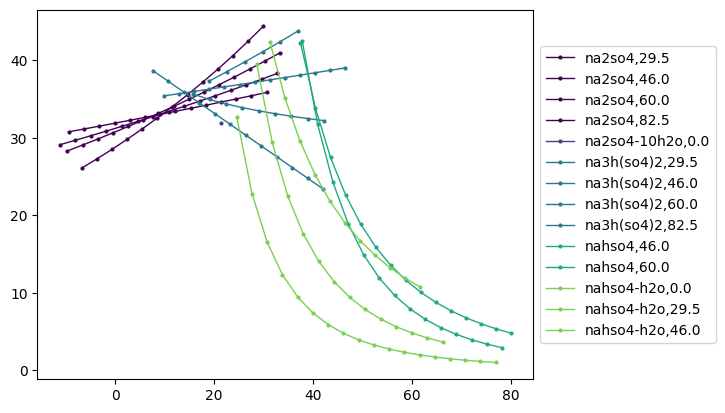

In [50]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def generate_color_dict(string_list, colormap_name='viridis'):
    # Get the colormap
    cmap = plt.get_cmap(colormap_name)
    
    # Calculate the step size for evenly distributed colors
    n = len(string_list)
    step = 1.0 / n
    
    # Generate the color dictionary
    color_dict = {}
    for i, s in enumerate(string_list):
        # Get color from colormap and convert to hex
        rgba = cmap(i * step)
        hex_color = mcolors.rgb2hex(rgba)
        color_dict[s] = hex_color
    
    return color_dict


plot_df = sim_df[(sim_df['y_extrapolate']<45) & (sim_df['x_extrapolate']<80)]
color_map = generate_color_dict(plot_df['solid'].unique().tolist(), colormap_name='viridis')
fig, ax = plt.subplots(1,1)
plt.close()
for (solid, temp), group_df in plot_df.groupby(by=['solid','temp']):
    ax.plot(
        group_df['x_extrapolate'],group_df['y_extrapolate'],
        marker='.', markersize=4,
        linewidth=1, linestyle='-',
        label=f"{solid},{temp}", color=color_map.get(solid)
    )

ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
display(fig)


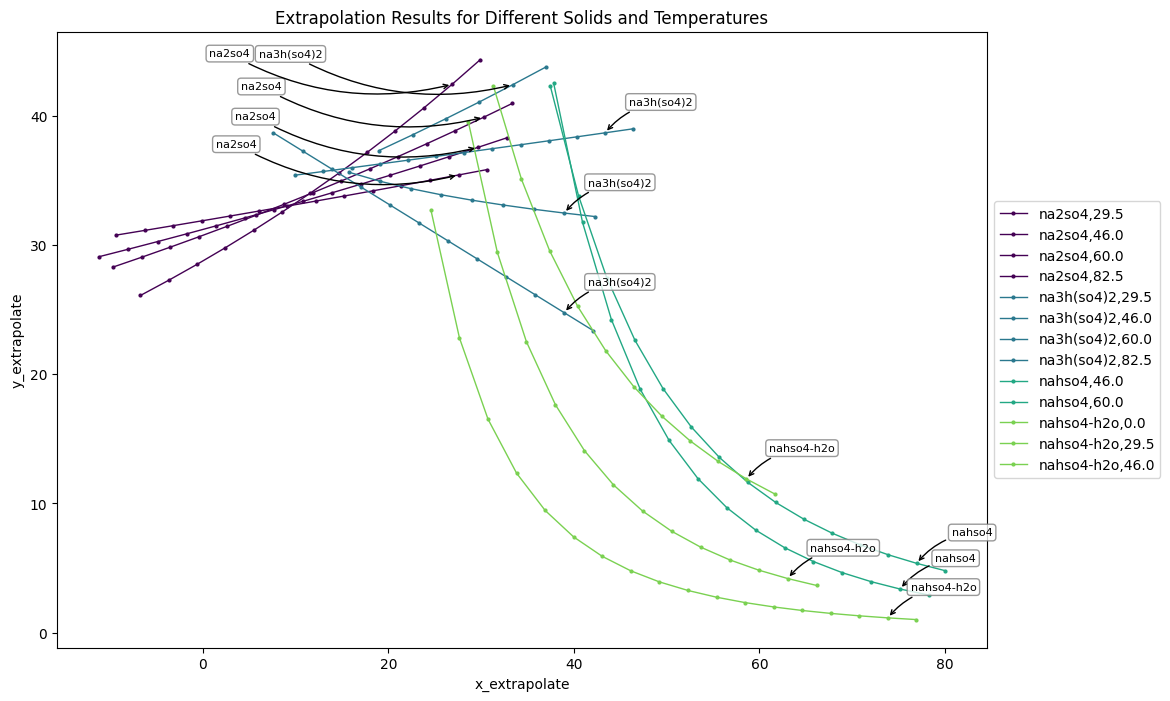

<Figure size 640x480 with 0 Axes>

In [96]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def generate_color_dict(string_list, colormap_name='viridis'):
    # Get the colormap
    cmap = plt.get_cmap(colormap_name)
    
    # Calculate the step size for evenly distributed colors
    n = len(string_list)
    step = 1.0 / n
    
    # Generate the color dictionary
    color_dict = {}
    for i, s in enumerate(string_list):
        # Get color from colormap and convert to hex
        rgba = cmap(i * step)
        hex_color = mcolors.rgb2hex(rgba)
        color_dict[s] = hex_color
    
    return color_dict
    
plot_df = sim_df[(sim_df['y_extrapolate']<45) & (sim_df['x_extrapolate']<80)]
color_map = generate_color_dict(plot_df['solid'].unique().tolist(), colormap_name='viridis')
fig, ax = plt.subplots(1,1, figsize=(12, 8))  # Increased figure size for better visibility
plt.close()

split_percent = 0.1
x_mid = (plot_df['x_extrapolate'].max()- plot_df['x_extrapolate'].min())/2
x_max = plot_df['x_extrapolate'].max()
x_min = plot_df['x_extrapolate'].min()
x_split = x_mid-split_percent*(x_max-x_min)
y_mid = (plot_df['y_extrapolate'].max()- plot_df['y_extrapolate'].min())/2

for (solid, temp), group_df in plot_df.groupby(by=['solid','temp']):
    if group_df.shape[0]<2:
        continue
    line, = ax.plot(
        group_df['x_extrapolate'], group_df['y_extrapolate'],
        marker='.', markersize=4,
        linewidth=1, linestyle='-',
        label=f"{solid},{temp}", color=color_map.get(solid)
    )
    
    # Add annotation
    # Choose a point for annotation (e.g., the midpoint of the line)
    
    x_pos = group_df['x_extrapolate'].iloc[-2]
    y_pos = group_df['y_extrapolate'].iloc[-2]
    if x_pos>=x_split:
        x_offset_sign = 1
        xytext=(x_offset_sign*40,20)
    else:
        x_offset_sign = -4
        xytext=(x_offset_sign*40,20)
    
    # Add text annotation
    ax.annotate(f"{solid}", 
                (x_pos, y_pos),
                textcoords="offset points",
                xytext=xytext,   # Offset the text 10 points above the point
                ha='center',     # Horizontally center the text
                fontsize=8,      # Smaller font size
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2"))

ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set_xlabel('x_extrapolate')
ax.set_ylabel('y_extrapolate')
ax.set_title('Extrapolation Results for Different Solids and Temperatures')
plt.tight_layout()
display(fig)

## Dev finding regions and tie lines

Storing fits for specific temperature/ solid data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator

def create_model_storage_df():
    """Create an empty DataFrame for storing model information."""
    return pd.DataFrame(columns=[
        'solid', 'temp', 'model_type', 'parameters', 'mse'
    ])

def add_model_to_storage(storage_df, solid, temp, model_type, pipeline, mse):
    """Add model information to the storage DataFrame."""
    parameters = extract_parameters(pipeline)
    new_row = pd.DataFrame({
        'solid': [solid],
        'temp': [temp],
        'model_type': [model_type],
        'parameters': [parameters],
        'mse': [mse]
    })
    return pd.concat([storage_df, new_row], ignore_index=True)

def extract_parameters(pipeline):
    """Extract essential parameters from a pipeline."""
    final_step = pipeline.steps[-1][1]
    if isinstance(final_step, LinearRegression):
        return {
            'coefficients': final_step.coef_.tolist(),
            'intercept': final_step.intercept_
        }
    elif isinstance(final_step, (PowerRegressor, ExponentialRegressor)):
        return {'coefficients': final_step.coef_.tolist()}
    elif isinstance(final_step, BaseEstimator):
        return final_step.get_params()
    else:
        return {}  # For unsupported model types

def get_model_info(storage_df, solid, temp):
    """Retrieve model information from the storage DataFrame."""
    model_info = storage_df[(storage_df['solid'] == solid) & (storage_df['temp'] == temp)]
    return model_info.iloc[0] if not model_info.empty else None

def predict_with_model_info(model_info, x):
    """Make predictions using stored model information."""
    if model_info is None:
        return None
    
    model_type = model_info['model_type']
    params = model_info['parameters']
    
    if model_type == 'linear':
        return np.dot(x, params['coefficients']) + params['intercept']
    elif model_type == 'poly_2':
        return np.polyval([params['coefficients'][1], params['coefficients'][0], params['intercept']], x)
    elif model_type == 'power':
        return params['coefficients'][0] * np.power(x, params['coefficients'][1])
    elif model_type == 'exponential':
        return params['coefficients'][0] * np.exp(params['coefficients'][1] * x)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

# Usage in your existing code:
model_storage = create_model_storage_df()

# Inside your loop where you fit models:
for (solid, temp), df in _df.groupby(by=['solid', 'temp']):
    best_fit_name = df.iloc[0]['recommended_fit']
    if best_fit_name is None or df.iloc[0][best_fit_name] > mse_threshold:
        continue
    
    pipeline = pipelines.get(best_fit_name)
    x = raw_df[(raw_df['solid']==solid) & (raw_df['temp']==temp)][x_name].values
    y = raw_df[(raw_df['solid']==solid) & (raw_df['temp']==temp)][y_name].values 
    X = x.reshape(-1, 1)
    pipeline.fit(X, y)
    
    # Add the model information to storage
    model_storage = add_model_to_storage(
        model_storage, solid, temp, best_fit_name, pipeline, df.iloc[0][best_fit_name]
    )

# Example of using the stored model information:
# solid = 'some_solid'
# temp = 'some_temp'
# x_new = np.array([1, 2, 3])
# model_info = get_model_info(model_storage, solid, temp)
# if model_info is not None:
#     predictions = predict_with_model_info(model_info, x_new)
#     print(f"Predictions for {solid} at {temp}: {predictions}")

# To save the model information for later use:
# model_storage.to_pickle('model_storage.pkl')

# To load the model information later:
# loaded_model_storage = pd.read_pickle('model_storage.pkl')

Finding roots from interpolations

In [ ]:
import numpy as np
from scipy import optimize

def extend_x_range(x_min, x_max, extension_factor=2):
    """Extend the x range for extrapolation."""
    range_width = x_max - x_min
    new_min = x_min - range_width * (extension_factor - 1) / 2
    new_max = x_max + range_width * (extension_factor - 1) / 2
    return new_min, new_max

def find_intersection(regressor1, regressor2, x_min, x_max):
    """Find the intersection between two sklearn regressors."""
    def difference(x):
        return regressor1.predict([[x]])[0] - regressor2.predict([[x]])[0]
    
    # Extend the search range
    x_min_ext, x_max_ext = extend_x_range(x_min, x_max)
    
    # Find zero crossings
    root = optimize.brentq(difference, x_min_ext, x_max_ext)
    y = regressor1.predict([[root]])[0]
    
    return root, y

def find_all_intersections(regressors, x_min, x_max):
    """Find intersections between all pairs of regressors."""
    intersections = []
    for i in range(len(regressors)):
        for j in range(i+1, len(regressors)):
            try:
                x, y = find_intersection(regressors[i], regressors[j], x_min, x_max)
                intersections.append((x, y, i, j))
            except ValueError:
                # No intersection found
                pass
    
    return intersections

# Example usage
# Assuming you have a list of sklearn regressors and x_min, x_max values

# regressors = [regressor1, regressor2, regressor3]  # Your sklearn regressors
# x_min = ...  # Your minimum x value
# x_max = ...  # Your maximum x value

# intersections = find_all_intersections(regressors, x_min, x_max)
# for x, y, i, j in intersections:
#     print(f"Intersection between regressor {i} and regressor {j} at x={x:.2f}, y={y:.2f}")

In [23]:
# how to lookup
#1. given a temp choose the closest lines in our interpolated dataset
# - temp must be aabove lowest and below highest

#2. Given an x
# - compute y(temp) for upper and lower interpolant

#3. Perform a linear interpolation between upper and lower at x
# - computes best y at an unknown temp



# Dev

Skipping solid='-', temp=0.0
-- Bad MSE [30.07398122642574]. Skipping fit for now
Skipping solid='-', temp=29.5
-- Bad MSE [1.0993886954177008]. Skipping fit for now
Skipping solid='-', temp=46.0
-- Bad MSE [5.044588069183912]. Skipping fit for now
Skipping solid='-', temp=60.0
-- Bad MSE [23.719674835945835]. Skipping fit for now
Skipping solid='-', temp=82.5
-- Bad MSE [18.255927103147453]. Skipping fit for now
Skipping solid='na2so4-10h2o', temp=29.5
-- Not enough data to fit Skipping fit for now
Skipping solid='na3h(so4)2', temp=0.0
-- Not enough data to fit Skipping fit for now
Skipping solid='nahso4', temp=0.0
-- Not enough data to fit Skipping fit for now
Skipping solid='nahso4', temp=29.5
-- Not enough data to fit Skipping fit for now
Skipping solid='nahso4 + na3h(so4)2 + nahso4-h2o', temp=29.5
-- Not enough data to fit Skipping fit for now


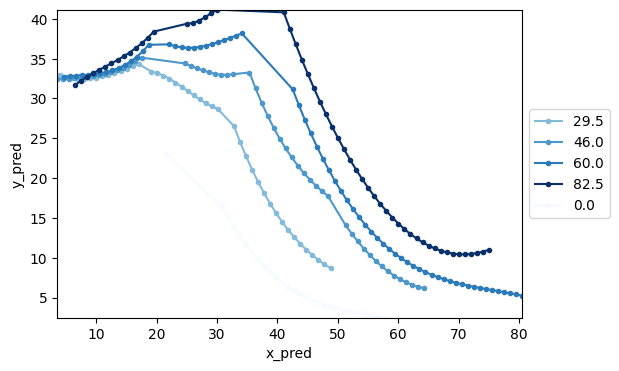

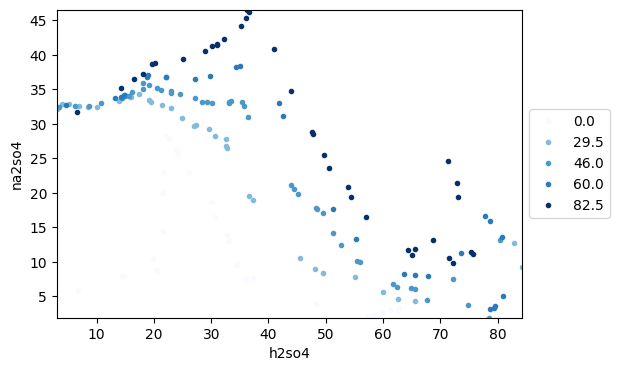

In [94]:
x_name = 'h2so4'
y_name = 'na2so4'

_df = stats_df.copy()
#create interpolant and plot smoothed functions
pipelines = {
    "linear": make_pipeline(LinearRegression()),
    "poly_2": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    "poly_3": make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
    "power": make_pipeline(PowerRegressor()),
    "exponential": make_pipeline(ExponentialRegressor())
}
#drop bad fits for now with MSE threshold
mse_threshold = 1

sim_df = pd.DataFrame()
for (solid, temp), df in _df.groupby(by=['solid', 'temp']):
    best_fit_name = df.iloc[0]['recommended_fit']
    if best_fit_name is None:
        print(f"Skipping {solid=}, {temp=}")
        print(f"-- Not enough data to fit Skipping fit for now")
        continue
    
    best_fit_mse = df.iloc[0][best_fit_name]
    if best_fit_mse>mse_threshold:
        print(f"Skipping {solid=}, {temp=}")
        print(f"-- Bad MSE [{best_fit_mse}]. Skipping fit for now")
        continue
    #create simulated data
    pipeline = pipelines.get(best_fit_name)
    x = raw_df[(raw_df['solid']==solid) & (raw_df['temp']==temp)][x_name].values
    y = raw_df[(raw_df['solid']==solid) & (raw_df['temp']==temp)][y_name].values 
    X = x.reshape(-1, 1)
    pipeline.fit(X, y)
    x_pred = np.arange(df.iloc[0]['x_min'],df.iloc[0]['x_max'],step = 1)
    X_pred = x_pred.reshape(-1,1)
    y_pred = pipeline.predict(X_pred)
    df = pd.DataFrame({
        'x_pred' : x_pred,
        'y_pred': y_pred,
    })
    df['solid'] = solid
    df['temp'] = temp
    sim_df = pd.concat([sim_df,df])
    
    
# display(sim_df)
temperatures = raw_df['temp'].unique().tolist()
custom_cmap, norm = generate_temperature_colormap(temperatures, cmap_name='Blues')
fig = plot_data(
    sim_df,
    x_name = 'x_pred',
    y_name = 'y_pred',
    series_name= 'temp',
    title='',
    marker='.',
    color_map = (custom_cmap, norm)
)
display(fig)
fig_raw = plot_data(
    raw_df,
    x_name = x_name,
    y_name = y_name,
    series_name= 'temp',
    title='',
    marker='.',
    linewidth=0,
    color_map = (custom_cmap, norm),
)
display(fig_raw)


In [6]:
df = raw_df[raw_df['solid']=='nahso4'].copy()
df = df[df['temp']==82.5]
# display(df)

x = df['h2so4'].values
y = df['na2so4'].values

#### Determine best fitting function
# 1. Define the fitting pipelines
# - Custom transformer for power function

pipelines = {
    "Linear": make_pipeline(LinearRegression()),
    "Polynomial (2nd degree)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    "Polynomial (3rd degree)": make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
    "Power": make_pipeline(PowerRegressor()),
    "Exponential": make_pipeline(ExponentialRegressor())
}


# 2. Fit process and compute rank metrics
results = {}
X = x.reshape(-1, 1)

# - fit, predict, compute error metrics

for name, pipeline in pipelines.items():
    pipeline.fit(X, y)
    y_pred = pipeline.predict(X)
    
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    results[name] = {"pipeline": pipeline, "y_pred": y_pred, "MSE": mse, "R^2": r2}

# 3. Compile into a dta frame
# Create a summary DataFrame
summary_data = []

for name, metrics in results.items():
    row = {"Model": name, "MSE": metrics["MSE"], "R^2": metrics["R^2"]}
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
display(summary_df)
best_model = summary_df.loc[summary_df['MSE'].idxmin(), 'Model']
print(best_model)

,Model,MSE,R^2
0,Linear,11.775218,0.861797
1,Polynomial (2nd degree),0.138098,0.998379
2,Polynomial (3rd degree),0.134899,0.998417
3,Power,1.368887,0.983934
4,Exponential,3.630884,0.957385


Polynomial (3rd degree)


In [135]:
import pandas as pd
import matplotlib.pyplot as plt

import bizwiz
path_manager = bizwiz.PathManager(
    data_dir = "../data/"
)

In [136]:
csv_files = path_manager.find_data_files(suffix='.csv')
csv_filepath = csv_files[0]



In [137]:
df.groupby(by=['solid','temp']).count()

h2so4  na2so4
solid                            temp               
-                                0.0      18      18
                                 29.5      8       8
                                 46.0     12      12
                                 60.0     10      10
                                 82.5     13      13
na2so4                           29.5     11      11
                                 46.0     11      11
                                 60.0      6       6
                                 82.5      5       5
na2so4-10h2o                     0.0       3       3
                                 29.5      1       1
na3h(so4)2                       0.0       1       1
                                 29.5      9       9
                                 46.0      8       8
                                 60.0      5       5
                                 82.5      5       5
nahso4                           0.0       1       1
                                 29.5      1       1
                                 46.0      7       7
                                 60.0      6       6
                                 82.5     13      11
nahso4 + na3h(so4)2 + nahso4-h2o 29.5      1       1
nahso4-h2o                       0.0       4       4
                                 29.5      6       6
                                 46.0      8       8

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

def generate_temperature_colormap(temperatures, cmap_name='coolwarm'):
    """
    Generate a colormap based on a list of temperature values.

    Parameters:
    temperatures (list or array): List of temperature values
    cmap_name (str): Name of the colormap to use (default is 'coolwarm')

    Returns:
    tuple: (colormap, norm) where colormap is a LinearSegmentedColormap and 
           norm is a Normalize object for mapping temperatures to colors
    """
    # Create a normalize object based on min and max temperatures
    norm = Normalize(vmin=min(temperatures), vmax=max(temperatures))
    
    # Create the colormap
    cmap = plt.get_cmap(cmap_name)
    
    # Create a LinearSegmentedColormap that's specific to our temperature range
    colors = cmap(norm(temperatures))
    custom_cmap = LinearSegmentedColormap.from_list("custom", colors)
    
    return custom_cmap, norm

def precompute_colors(values, cmap, norm):
    """
    Precompute colors for given values using a colormap and normalization.
    
    Parameters:
    values (array-like): The values to map to colors
    cmap (Colormap): The colormap to use
    norm (Normalize): The normalization object
    
    Returns:
    list: List of RGBA color tuples
    """
    return [cmap(norm(value)) for value in values]

import numpy as np

def generate_line_thicknesses(n, min_thickness=1, max_thickness=3):
    """
    Generate n line thicknesses from min to max.
    
    Parameters:
    n (int): Number of line thicknesses to generate
    min_thickness (float): Minimum line thickness
    max_thickness (float): Maximum line thickness
    
    Returns:
    list: List of n line thicknesses
    """
    return list(np.linspace(min_thickness, max_thickness, n))

def generate_dash_patterns(n, min_dash=2, max_dash=10, gap=2):
    """
    Generate n dash patterns from small to long dashes with a fixed gap.
    
    Parameters:
    n (int): Number of dash patterns to generate
    min_dash (float): Minimum dash length
    max_dash (float): Maximum dash length
    gap (float): Fixed length of gap between dashes
    
    Returns:
    list: List of n dash patterns (each a tuple for dash pattern)
    """
    dash_lengths = np.linspace(min_dash, max_dash, n)
    return [(0,(length, gap)) for length in dash_lengths]

def generate_marker_sizes(n, min_size=2, max_size=10):
    """
    Generate n marker sizes for '.' marker from small to large.
    
    Parameters:
    n (int): Number of marker sizes to generate
    min_size (float): Minimum marker size
    max_size (float): Maximum marker size
    
    Returns:
    list: List of n marker sizes
    """
    return list(np.linspace(min_size, max_size, n))

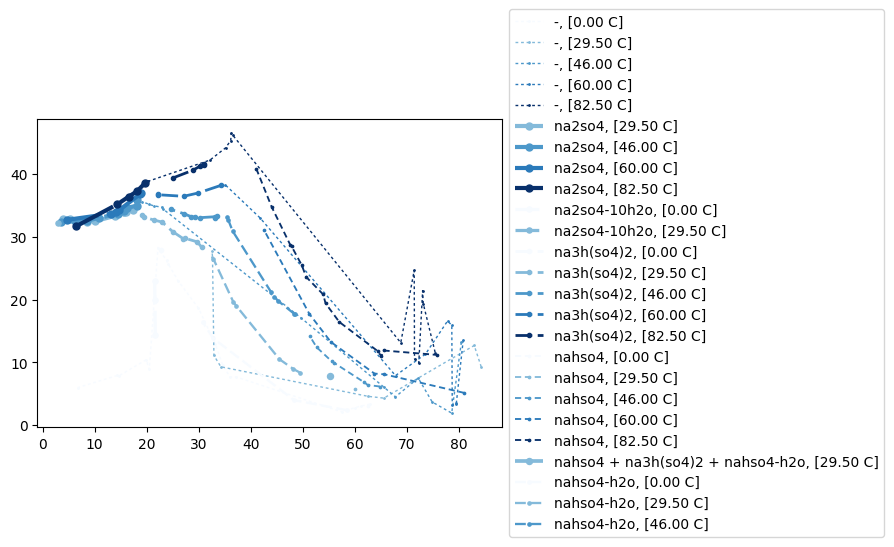

In [139]:
df = pd.read_csv(csv_filepath)
df = df[['temp','h2so4','na2so4','solid']].copy()
df['solid'] = df['solid'].fillna(value='-')


series_info = {solid: {} for solid in df['solid'].unique().tolist()}
n_series = len(series_info)

# Generate style variations
thicknesses = generate_line_thicknesses(n_series, min_thickness=1, max_thickness=3)
dash_patterns = generate_dash_patterns(n_series, min_dash=2, max_dash=10, gap=2)
marker_sizes = generate_marker_sizes(n_series, min_size=2, max_size=10)

#overrides
series_overides = {
    "-" : {'marker' : '.', 'markersize' : 1, 'linewidth' : 0,},
    "default" : {'marker' : '.', 'markersize' : 0, 'linestyle' : '-', 'linewidth' : 0,},
}


#compile styles
for i, (solid, info) in enumerate(series_info.items()):
    info.update({
        'linewidth': thicknesses[i],
        'linestyle': dash_patterns[i],  # This now includes a fixed gap
        'markersize': marker_sizes[i],
        'marker': '.',
    })
    overides = series_overides.get(solid,None)
    if overides is not None:
        info = overides

#build color map
temperatures = df['temp'].unique()
custom_cmap, norm = generate_temperature_colormap(temperatures, cmap_name='Blues')

fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.close()
for group_ids, group_df in df.groupby(by=['solid','temp']):
    x_name = 'h2so4'
    y_name = 'na2so4'
    solid, temp, *_ = group_ids
    color_name = custom_cmap(norm(temp))
    series_kwargs = series_info.get(solid,series_info.get('default',{}))
    
    label = f"{solid}, [{temp:0.2f} C]"
    ax.plot(
        group_df[x_name], group_df[y_name], 
        label=label,
        color=color_name,
        **series_kwargs,
    )
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
display(fig)

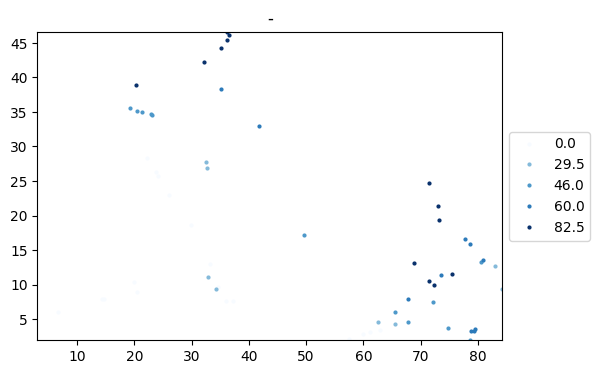

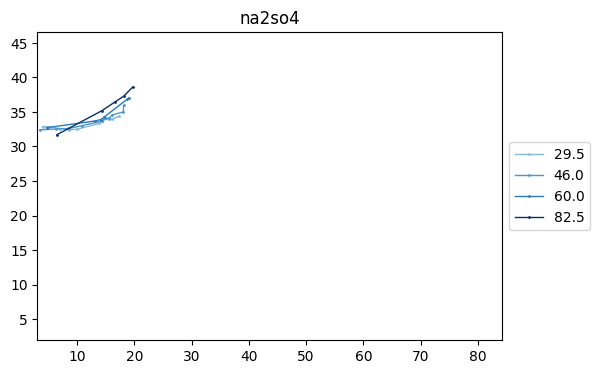

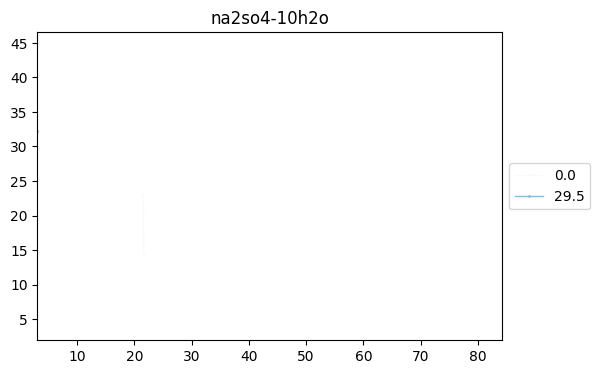

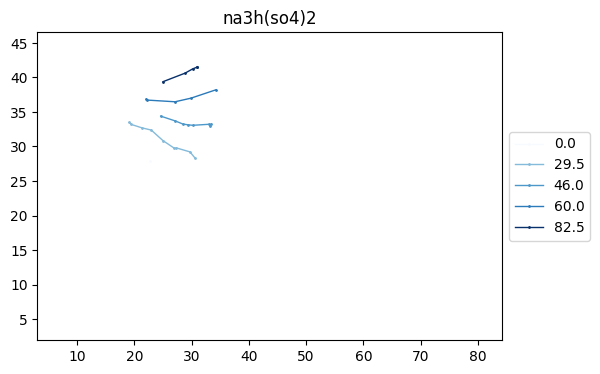

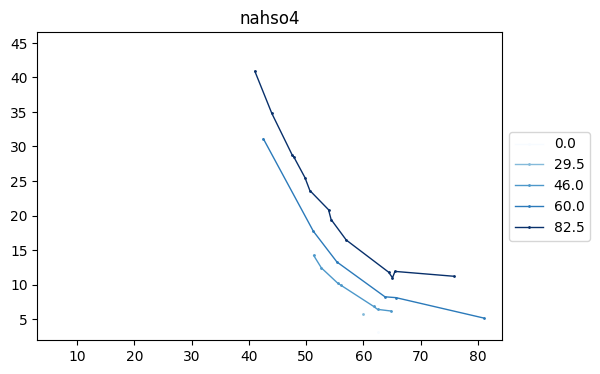

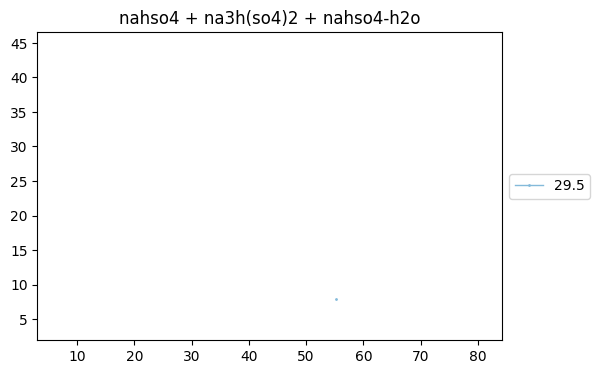

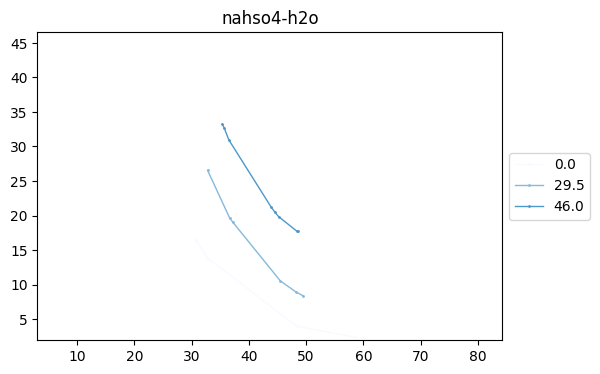

In [140]:
df = pd.read_csv(csv_filepath)
df = df[['temp','h2so4','na2so4','solid']].copy()
df['solid'] = df['solid'].fillna(value='-')


series_default = {'marker' : '.', 'markersize' : 2, 'linestyle' : '-', 'linewidth' : 1,}
series_info = {solid: series_default for solid in df['solid'].unique().tolist()}

# Generate style variation overides
# n_series = len(series_info)
# thicknesses = generate_line_thicknesses(n_series, min_thickness=1, max_thickness=3)
# dash_patterns = generate_dash_patterns(n_series, min_dash=2, max_dash=10, gap=2)
# marker_sizes = generate_marker_sizes(n_series, min_size=2, max_size=10)
# for i, (solid, info) in enumerate(series_info.items()):
#     info.update({
#         'linewidth': thicknesses[i],
#         'linestyle': dash_patterns[i],  # This now includes a fixed gap
#         'markersize': marker_sizes[i],
#         'marker': '.',
#     })

#force something explicitly
series_explicit = {
    "-" : {'marker' : '.', 'markersize' : 4, 'linewidth' : 0,},
}
for solid, info in series_explicit.items():
    series_info[solid] = info

#build color map
x_name = 'h2so4'
y_name = 'na2so4'
    
temperatures = df['temp'].unique()
xmin = df[x_name].min()
xmax = df[x_name].max()
ymin = df[y_name].min()
ymax = df[y_name].max()
custom_cmap, norm = generate_temperature_colormap(temperatures, cmap_name='Blues')


for group_ids, group_df in df.groupby(by=['solid']):
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    plt.close()

    solid, *_ = group_ids
    series_kwargs = series_info.get(solid,series_info.get('default',{}))
    
    temps = group_df['temp'].unique().tolist()
    for temp in temps:
        color_name = custom_cmap(norm(temp))
        plot_df = group_df[group_df['temp']==temp]
        label = f"{solid}, [{temp:0.2f} C]"
        ax.plot(
            plot_df[x_name], plot_df[y_name], 
            label=temp,
            color=color_name,
            **series_kwargs,
        )
    ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    ax.set(title=solid, xlim=(xmin, xmax), ylim=(ymin, ymax))
    display(fig)

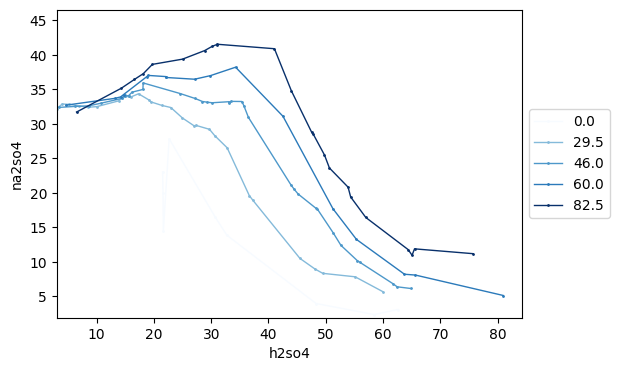

In [141]:
df = pd.read_csv(csv_filepath)
df = df[['temp','h2so4','na2so4','solid']].copy()
df['solid'] = df['solid'].fillna(value='-')


#build color map
x_name = 'h2so4'
y_name = 'na2so4'
    
temperatures = df['temp'].unique()
xmin = df[x_name].min()
xmax = df[x_name].max()
ymin = df[y_name].min()
ymax = df[y_name].max()
custom_cmap, norm = generate_temperature_colormap(temperatures, cmap_name='Blues')

fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.close()

temps = df['temp'].unique().tolist()
for temp in temps:
    color = custom_cmap(norm(temp))
    plot_df = df[df['temp']==temp]
    plot_df = plot_df[~plot_df['solid'].isin(['-'])]
    plot_df = plot_df.sort_values(by=[x_name])
    ax.plot(
        plot_df[x_name], plot_df[y_name], 
        label=temp,
        color=color,
        **series_kwargs,
    )
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set(
    xlabel=x_name, ylabel=y_name,
    xlim=(xmin, xmax), ylim=(ymin, ymax))
display(fig)

# Interpolation

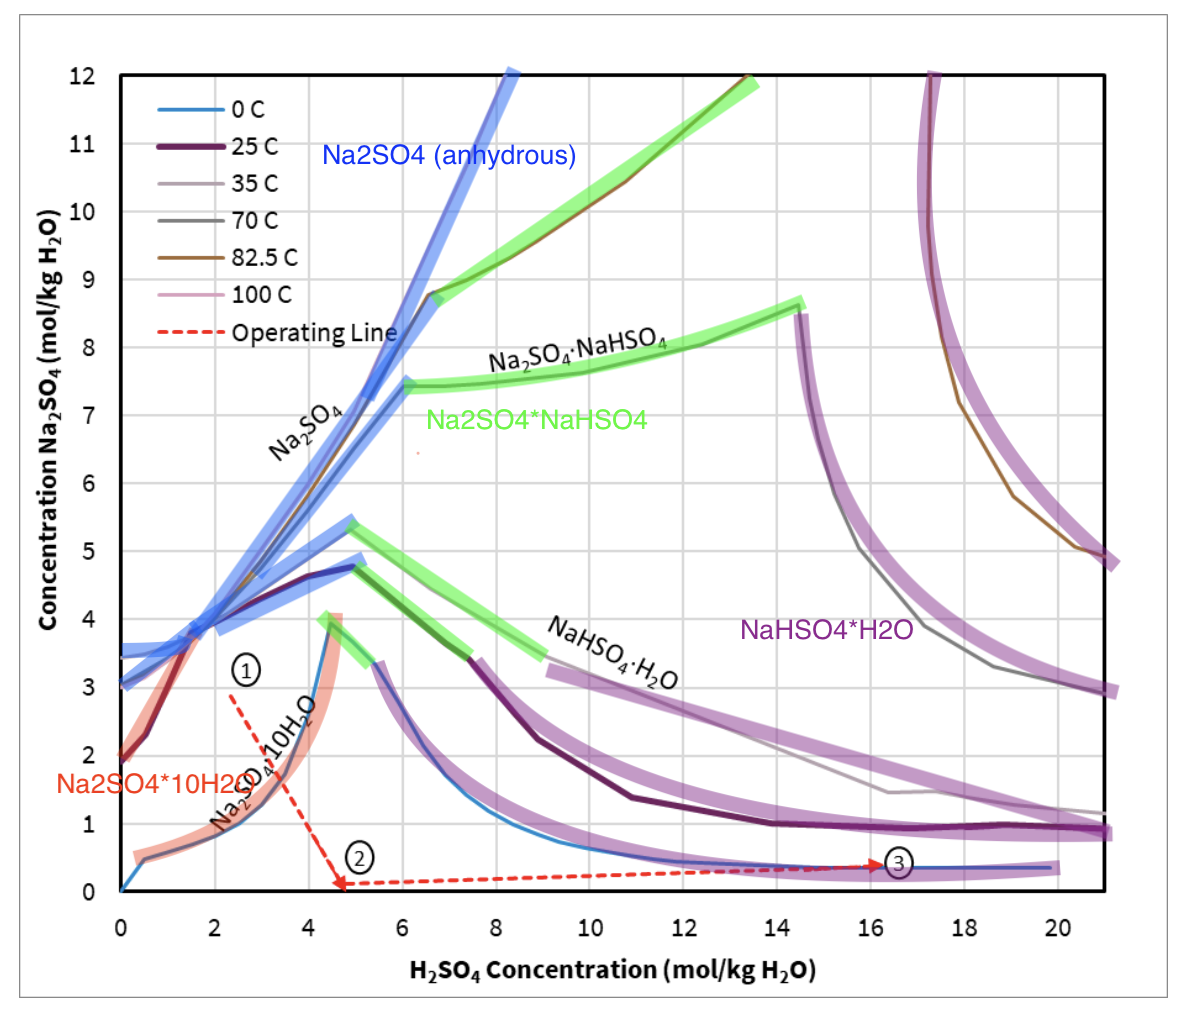

In [215]:
df.groupby(by=['solid','temp']).count()

h2so4  na2so4
solid                            temp               
-                                0.0      18      18
                                 29.5      8       8
                                 46.0     12      12
                                 60.0     10      10
                                 82.5     13      13
na2so4                           29.5     11      11
                                 46.0     11      11
                                 60.0      6       6
                                 82.5      5       5
na2so4-10h2o                     0.0       3       3
                                 29.5      1       1
na3h(so4)2                       0.0       1       1
                                 29.5      9       9
                                 46.0      8       8
                                 60.0      5       5
                                 82.5      5       5
nahso4                           0.0       1       1
                                 29.5      1       1
                                 46.0      7       7
                                 60.0      6       6
                                 82.5     13      13
nahso4 + na3h(so4)2 + nahso4-h2o 29.5      1       1
nahso4-h2o                       0.0       4       4
                                 29.5      6       6
                                 46.0      8       8

In [303]:
df['solid'].unique().tolist()

['-',
 'nahso4',
 'nahso4-h2o',
 'na3h(so4)2',
 'na2so4-10h2o',
 'nahso4 + na3h(so4)2 + nahso4-h2o',
 'na2so4']

## Manual

In [304]:
def plot_data(
    df,
    x_name = 'h2so4',
    y_name = 'na2so4',
    series_name= 'temp',
    title='',
    colormap_name='viridis'
):
    _df = df.copy()
    _df = _df.sort_values(by=[series_name])
    if 'solid' in _df.columns:
        _df[~_df['solid'].isin(['-'])]
        
    #build color map

    temperatures = _df[series_name].unique().tolist()
    xmin = _df[x_name].min()
    xmax = _df[x_name].max()
    ymin = _df[y_name].min()
    ymax = _df[y_name].max()
    custom_cmap, norm = generate_temperature_colormap(temperatures, cmap_name=colormap_name)
    
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    plt.close()
    
    temps = df[series_name].unique().tolist()
    for temp in temps:
        color = custom_cmap(norm(temp))
        plot_df = _df[_df[series_name]==temp].copy()
        plot_df = plot_df.sort_values(by=[x_name])
        ax.plot(
            plot_df[x_name], plot_df[y_name], 
            label=temp,
            color=color,
            marker='.', markersize=5,
            linewidth=0,
        )
    ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    ax.set(
        title=title,
        xlabel=x_name, ylabel=y_name,
        xlim=(xmin, xmax), ylim=(ymin, ymax))
    return fig

def get_bounding_linspace(vals, num=10):
    return np.linspace(min(vals),max(vals), num=num)

['-', 'nahso4', 'nahso4-h2o', 'na3h(so4)2', 'na2so4-10h2o', 'nahso4 + na3h(so4)2 + nahso4-h2o', 'na2so4']


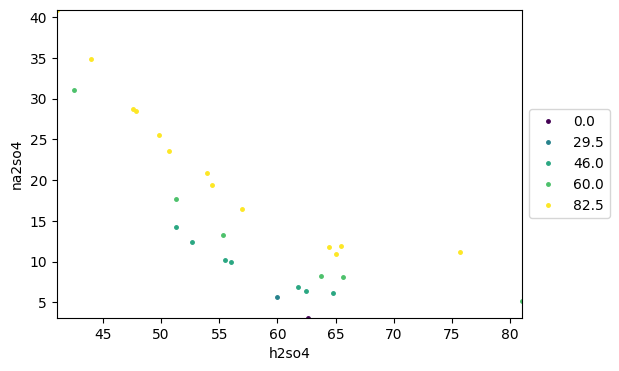

In [305]:
print(df['solid'].unique().tolist())
solid = 'nahso4'
data_df = df[df['solid'].isin([solid])].copy()
data_df
plot_data(
    data_df,
    x_name='h2so4',
    y_name='na2so4',
    series_name='temp',
)

### Fit temp isotherm lines

Generate smooth fits to the temp lines

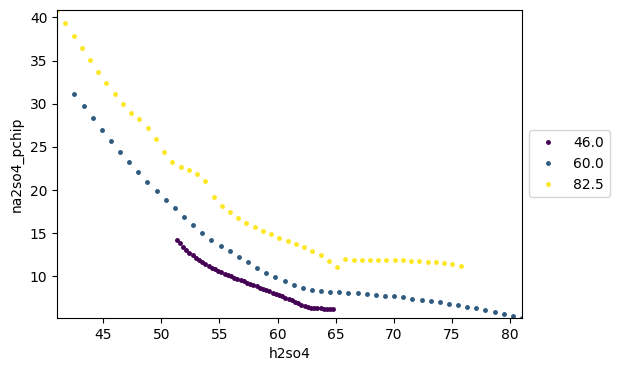

In [311]:
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator
x_name = 'h2so4'
y_name = 'na2so4'

data_df = data_df.sort_values(by=[x_name], ascending=[False])
# data_df = data_df[data_df['h2so4'].between(50,65)]

#fit interpolants
z_name = 'temp'
processed_df = pd.DataFrame()
num = 50
for groups, group_df in data_df.groupby(by=[z_name]):
    if group_df.shape[0]<=1:
        continue
    temp, *_ = groups
    x_range = get_bounding_linspace(group_df[x_name], num=num)
    _df = pd.DataFrame(data=x_range, columns = [x_name])
    _df[z_name] = temp

    fit_df = group_df.sort_values(by=[x_name], ascending=[True])
    cubic_spl = CubicSpline(fit_df[x_name], fit_df[y_name])
    pchip_spl = PchipInterpolator(fit_df[x_name], fit_df[y_name])
    akima_spl = Akima1DInterpolator(fit_df[x_name], fit_df[y_name])
    
    _df[f'{y_name}_cubic']  = cubic_spl(x_range)
    _df[f'{y_name}_pchip']  = pchip_spl(x_range)
    _df[f'{y_name}_akima']  = akima_spl(x_range)
    _df[y_name] = pchip_spl(x_range) #default
    processed_df = pd.concat([processed_df,_df])

plot_data(
    processed_df,
    x_name='h2so4',
    y_name='na2so4_pchip',
    series_name='temp',
)

### Interpolate on the grid of smoothed data

In [316]:
_df = processed_df.copy()

x_data = _df[x_name].values
y_data = _df[y_name].values
z_data = _df[z_name].values

from scipy.interpolate import griddata
def get_interpolation_grid(x,y, num=10):
    x_values = np.linspace(min(x),max(x), num=num)
    y_values = np.linspace(min(y),max(y), num=num)
    grid_x, grid_y = np.meshgrid(x_values, y_values, indexing='ij')
    return grid_x, grid_y


ivals = griddatax_data, y_data,z_data,grid_x,grid_y,interp='nn')

QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 152)

While executing:  | qhull d Q12 Qt Qbb Qc Qx Qz
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1543277597  delaunay  Q12-allow-wide  Qtriangulate  Qbbound-last
  Qcoplanar-keep  Qxact-merge  Qz-infinity-point  _zero-centrum  Qinterior-keep
  Q3-no-merge-vertices-dim-high  _maxoutside  0


In [261]:
from scipy.interpolate import griddata
def get_interpolation_grid(x,y, num=10):
    x_values = np.linspace(min(x),max(x), num=num)
    y_values = np.linspace(min(y),max(y), num=num)
    grid_x, grid_y = np.meshgrid(x_values, y_values, indexing='ij')
    return grid_x, grid_y
    
x_name = 'h2so4'
y_name = 'temp'
z_name = 'na2so4'

data_df = data_df.sort_values(by=[y_name,x_name])
x_data = data_df[x_name].values
y_data = data_df[y_name].values
z_data = data_df[z_name].values

grid_x, grid_y = get_interpolation_grid(
    x = np.linspace(45,70,num=10),
    y = np.linspace(5,30,num=10),, 
    num=10
)

grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')


## Claude

In [181]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

class MultiDirectional3DInterpolator:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.points = np.column_stack((x, y, z))

    def interpolate_z(self, x_new, y_new):
        return griddata(np.column_stack((self.x, self.y)), self.z, (x_new, y_new), method='linear')

    def interpolate_y(self, x_new, z_new):
        return griddata(np.column_stack((self.x, self.z)), self.y, (x_new, z_new), method='linear')

    def interpolate_x(self, y_new, z_new):
        return griddata(np.column_stack((self.y, self.z)), self.x, (y_new, z_new), method='linear')

def robust_test_z_interpolation(interpolator, x, y, n_samples=100):
    x_test = np.random.uniform(min(x), max(x), n_samples)
    y_test = np.random.uniform(min(y), max(y), n_samples)
    
    z_pred = interpolator.interpolate_z(x_test, y_test)
    
    return x_test, y_test, z_pred


def visualize_data(x, y, z, title, cmap='viridis'):
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=z, cmap=cmap)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    plt.colorbar(scatter)
    plt.close()
    return fig


def view_interpolation(x,y,z):

    # Split data into training and testing sets
    x_train, y_train, z_train = x, y, z

    x_test = x_train
    y_test = y_train
    z_test = z_train

    # Visualize training data
    fig = visualize_data(x_train, y_train, z_train, "Training Data")
    display(fig)
    
    # Create interpolator with training data
    interpolator = MultiDirectional3DInterpolator(x_train, y_train, z_train)

    #test interpolation
    x_pred, y_pred, z_pred = robust_test_z_interpolation(interpolator, x, y, n_samples=100)
    fig = visualize_data(x_pred, y_pred, z_pred, "Training Data")
    display(fig)



In [208]:
import numpy as np
from scipy.interpolate import griddata

class MultiDirectional3DInterpolator:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.points = np.column_stack((x, y, z))

    def interpolate_z(self, x_new, y_new):
        return griddata(np.column_stack((self.x, self.y)), self.z, (x_new, y_new), method='linear')

    def interpolate_y(self, x_new, z_new):
        return griddata(np.column_stack((self.x, self.z)), self.y, (x_new, z_new), method='linear')

    def interpolate_x(self, y_new, z_new):
        return griddata(np.column_stack((self.y, self.z)), self.x, (y_new, z_new), method='linear')

def plot_data(
    df,
    x_name = 'h2so4',
    y_name = 'na2so4',
    series_name= 'temp',
    title=''
):
    #build color map

    temperatures = df[series_name].unique().tolist()
    xmin = df[x_name].min()
    xmax = df[x_name].max()
    ymin = df[y_name].min()
    ymax = df[y_name].max()
    custom_cmap, norm = generate_temperature_colormap(temperatures, cmap_name='Blues')
    
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    plt.close()
    
    temps = df[series_name].unique().tolist()
    for temp in temps:
        color = custom_cmap(norm(temp))
        plot_df = df[df[series_name]==temp].copy()
        plot_df = plot_df[~plot_df['solid'].isin(['-'])]
        plot_df = plot_df.sort_values(by=[x_name])
        ax.plot(
            plot_df[x_name], plot_df[y_name], 
            label=temp,
            color=color,
        )
    ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    ax.set(
        title=title,
        xlabel=x_name, ylabel=y_name,
        xlim=(xmin, xmax), ylim=(ymin, ymax))
    return fig

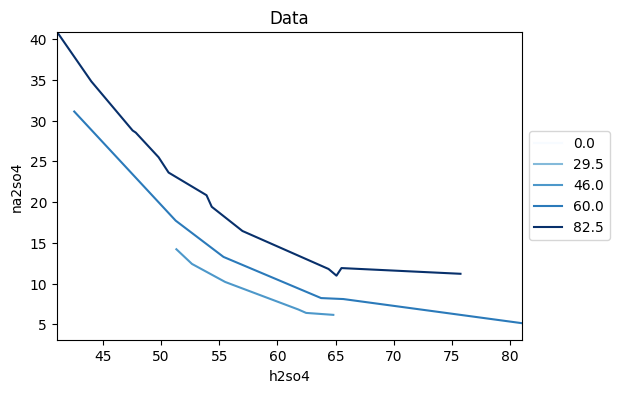

In [209]:
data_df = df[df['solid'].isin(['nahso4'])].copy()
fig = plot_data(
    data_df,
    x_name = 'h2so4',
    y_name = 'na2so4',
    series_name= 'temp',
    title='Data'
)
display(fig)

/tmp/ipykernel_108208/3234459515.py:51: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(


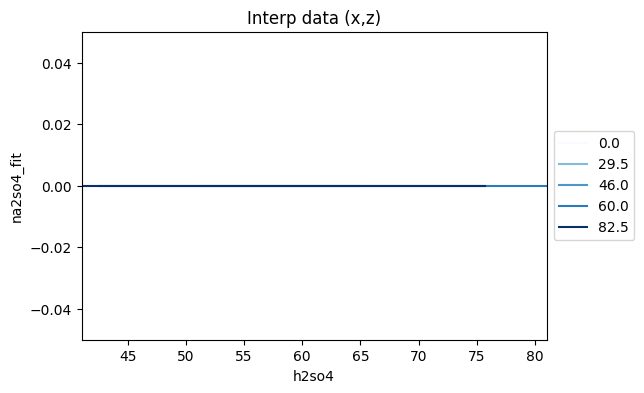

In [214]:
x = data_df['h2so4']
y = data_df['na2so4']
z = data_df['temp']
interpolator = MultiDirectional3DInterpolator(x, y, z)
fit_df = data_df.copy()
def interp_y(row):
    val = interpolator.interpolate_y(x_new=row['h2so4'], z_new=row['temp'])
    return round(float(),2)
    
fit_df['na2so4_fit'] = fit_df.apply(lambda row: interp_y(row), axis=1)

fig = plot_data(
    fit_df,
    x_name = 'h2so4',
    y_name = 'na2so4_fit',
    series_name= 'temp',
    title='Interp data (x,z)'
)
display(fig)

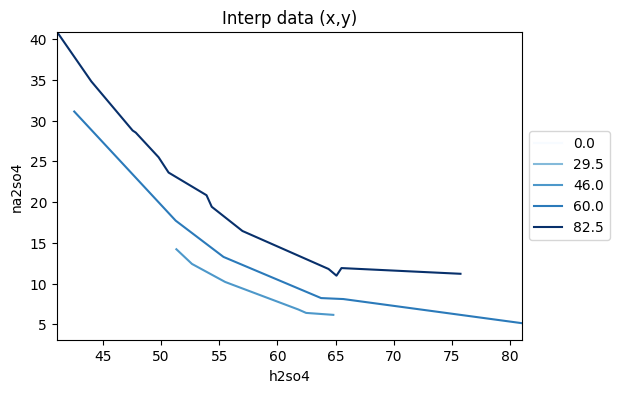

In [213]:
x = data_df['h2so4']
y = data_df['na2so4']
z = data_df['temp']
interpolator = MultiDirectional3DInterpolator(x, y, z)
fit_df = data_df.copy()
fit_df['temp_fit'] = fit_df.apply(lambda row: round(float(interpolator.interpolate_z(x_new=row['h2so4'], y_new=row['na2so4'])),2), axis=1)

fig = plot_data(
    fit_df,
    x_name = 'h2so4',
    y_name = 'na2so4',
    series_name= 'temp_fit',
    title='Interp data (x,y)'
)
display(fig)

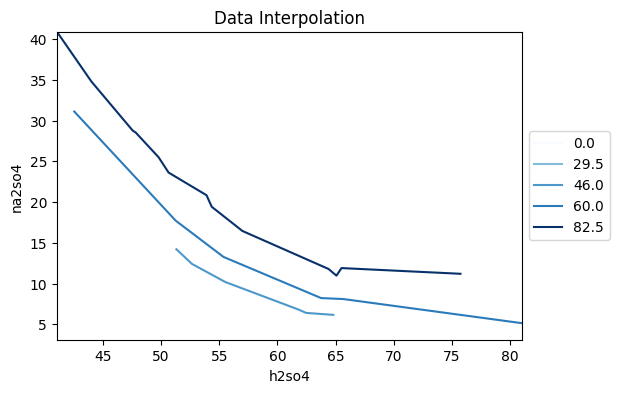

In [211]:
x = data_df['h2so4']
y = data_df['na2so4']
z = data_df['temp']
interpolator = MultiDirectional3DInterpolator(x, y, z)
fit_df = data_df.copy()
fit_df['temp_fit'] = fit_df.apply(lambda row: round(float(interpolator.interpolate_z(x_new=row['h2so4'], y_new=row['na2so4'])),2), axis=1)

fig = plot_data(
    fit_df,
    x_name = 'h2so4',
    y_name = 'na2so4',
    series_name= 'temp_fit',
    title='Data Interpolation'
)
display(fig)

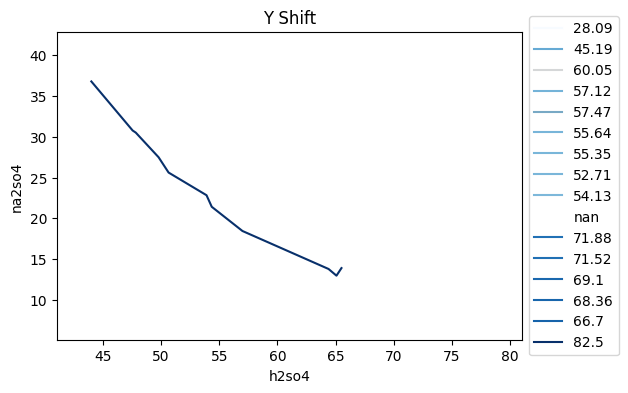

In [212]:
x = data_df['h2so4']
y = data_df['na2so4']
z = data_df['temp']
interpolator = MultiDirectional3DInterpolator(x, y, z)
fit_df = data_df.copy()
fit_df['na2so4'] = fit_df['na2so4'] + 2
fit_df['temp_fit'] = fit_df.apply(lambda row: round(float(interpolator.interpolate_z(x_new=row['h2so4'], y_new=row['na2so4'])),2), axis=1)

fig = plot_data(
    fit_df,
    x_name = 'h2so4',
    y_name = 'na2so4',
    series_name= 'temp_fit',
    title='Y Shift'
)
display(fig)

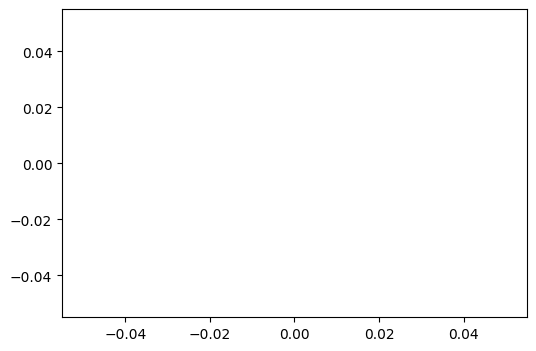

In [177]:
x = data_df['h2so4']
y = data_df['na2so4']
z = data_df['temp']
interpolator = MultiDirectional3DInterpolator(x, y, z)

n=50
z_vals = np.array(60)*n
y_vals = np.linspace(44,78,num=n)
x_vals = interpolator.interpolate_x(y_new=y_vals, z_new=z_vals)

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(x_vals,y_vals)

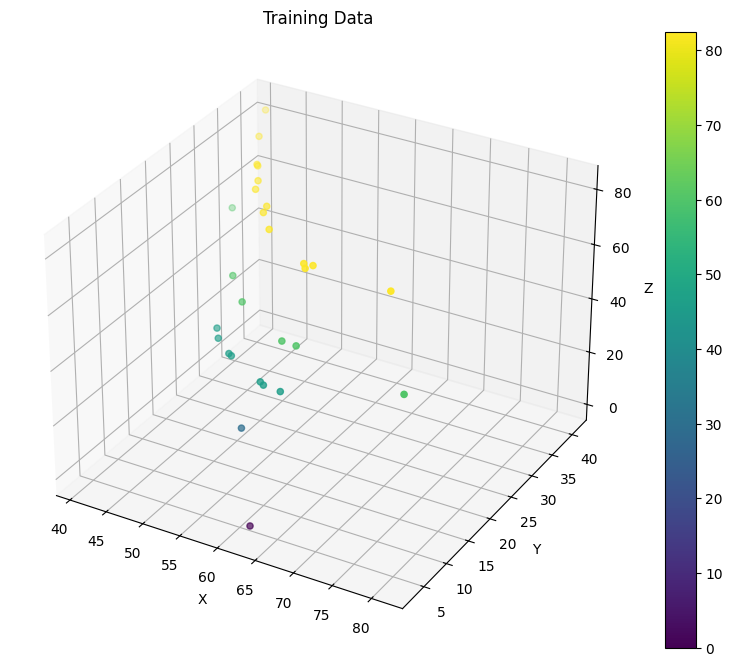

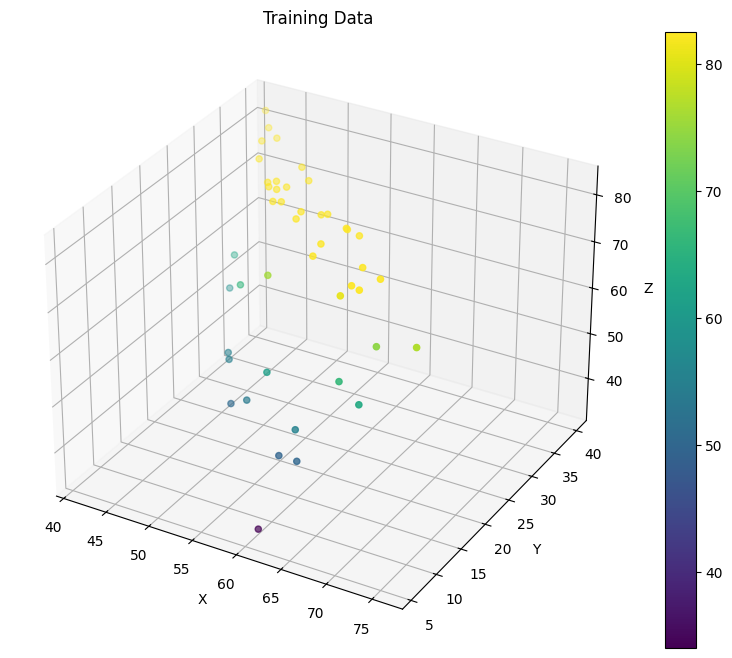

In [171]:
x = data_df['h2so4']
y = data_df['na2so4']
z = data_df['temp']
view_interpolation(x,y,z)